In [1]:
import pandas as pd
from nilearn import datasets
from nilearn.image import new_img_like, load_img

# We fetch 2nd subject from haxby datasets (which is default)
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels['labels']
session = labels['chunks']

Anatomical nifti image (3D) is located at: /Users/mlion0200/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/mlion0200/nilearn_data/haxby2001/subj2/bold.nii.gz


In [2]:
from nilearn.image import index_img
condition_mask = y.isin(['face', 'house'])

fmri_img = index_img(fmri_filename, condition_mask)
y, session = y[condition_mask], session[condition_mask]

In [3]:
import numpy as np

mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = mask_img.get_data().astype(np.int)
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

In [4]:
%matplotlib inline

In [27]:
mask_img

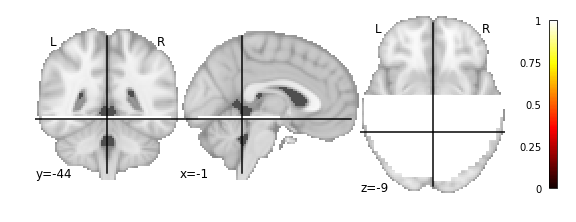

In [20]:
plotting.plot_stat_map(process_mask_img)

In [5]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 1

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=5.6, n_jobs=n_jobs,
    verbose=1, cv=cv)
searchlight.fit(fmri_img, y)

/anaconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.8s finished


SearchLight(cv=KFold(n_splits=4, random_state=None, shuffle=False),
      estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x1c17ed4d30>,
      n_jobs=1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0xa16889a90>,
      radius=5.6, scoring=None, verbose=1)

/anaconda3/envs/mne/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


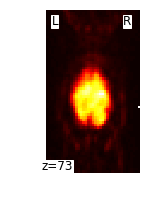

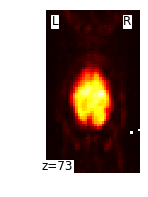

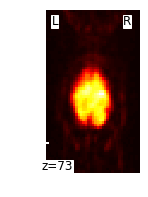

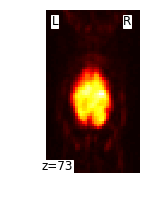

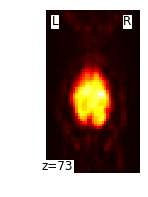

In [26]:
index = 1
for img in image.iter_img(fmri_img):
    if index > 5:
        break
    # img is now an in-memory 3D img
    plotting.plot_stat_map(img, threshold=3, display_mode="z", cut_coords=1,
                           colorbar=False)
    index = index + 1

In [6]:
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
                           standardize=True, memory='nilearn_cache',
                           memory_level=1)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = nifti_masker.inverse_transform(p_values).get_data()

/Users/mlion0200/.local/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='nilearn_cache'", use "location='nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/Users/mlion0200/.local/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/Users/mlion0200/.local/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [8]:
searchlight.scores

AttributeError: 'SearchLight' object has no attribute 'scores'

/anaconda3/envs/mne/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/anaconda3/envs/mne/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


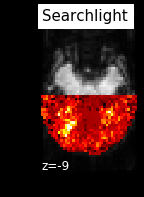

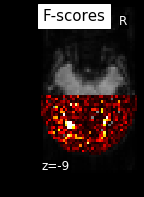

In [30]:
from nilearn import image
mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="z", cut_coords=[-9],
         vmin=.42, cmap='hot', threshold=.2, black_bg=True)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              title="F-scores", display_mode="z",
              cut_coords=[-9],
              colorbar=False)

show()

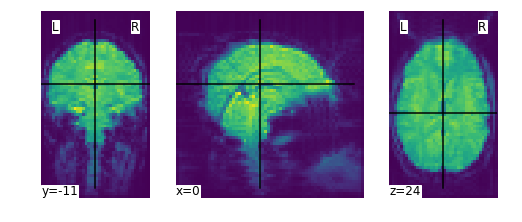

In [32]:
plot_img(mean_fmri)